In [3]:
import numpy as np
import pickle
import os
import jax
import optax

from glob import glob
from tqdm import tqdm
from PIL import Image
from jax import numpy as jnp
from flax import linen as nn
from matplotlib import pyplot as plt

from dataclasses import dataclass, field
from typing import Sequence, List

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".50"

In [64]:
def load_images():
    images_path = "./daisy-128/*"
    images = glob(images_path)
    items = []

    for image in images:
        test = Image.open(image)
        arr = jnp.asarray(test, dtype=jnp.float16) / 255.0
        items.append(arr)

    return jnp.array(items)

def get_batch(images, key, size=10):
    return jax.random.choice(key, images, shape=(size,))

@jax.jit
def denormalize(d):
    d = jnp.floor(d * 255.0)
    d = jnp.clip(d, 0, 255)
    return d

def view_batch_at(batch, index = 0):
    array = np.array(denormalize(batch[index]), dtype=np.int8)
    image = Image.fromarray(array, mode="RGB")
    return image

def batch_to_images(batch):
    images_array = np.array(denormalize(batch), dtype=np.int8)
    images = [Image.fromarray(image_array, mode="RGB") for image_array in images_array]
    return images

all_images = load_images()
all_images.shape

(10, 128, 128, 3)

In [70]:
class Encoder(nn.Module):
    channels: Sequence[int] = field(default_factory=lambda: [8, 16, 32])
    strides: (int, int) = (2, 2)
    kernel: (int, int) = (4, 4)
    kernel_init: nn.initializers.Initializer = nn.initializers.lecun_normal()
    bias_init: nn.initializers.Initializer = nn.initializers.zeros

    @nn.compact
    def __call__(self, inputs):

        def conv(img, features):
            img = nn.Conv(features=features, kernel_size=self.kernel)(img)
            img = nn.leaky_relu(img)
            img = nn.avg_pool(img, window_shape=self.strides, strides=self.strides)
            return img

        x = inputs
        for c in self.channels:
            x = conv(x, c)

        return x

class Decoder(nn.Module):
    channels: Sequence[int] = field(default_factory=lambda: [16, 8, 3])
    strides: (int, int) = (2, 2)
    kernel: (int, int) = (4, 4)
    kernel_init: nn.initializers.Initializer = nn.initializers.lecun_normal()
    bias_init: nn.initializers.Initializer = nn.initializers.zeros

    @nn.compact
    def __call__(self, inputs):

        def unconv(img, features):
            img = nn.ConvTranspose(features=features, kernel_size=self.kernel, strides=self.strides)(img)
            img = nn.leaky_relu(img)
            return img

        x = inputs
        for c in self.channels:
            x = unconv(x, c)

        return x

class VQVAE(nn.Module):
    channels: Sequence[int] = field(default_factory=lambda: [3, 8, 16, 32, 64])
    embeddings: int = 256
    embeddings_init: nn.initializers.Initializer = nn.initializers.normal()
    commitment_cost: float = 0.25

    def setup(self):
        self.encoder = Encoder(channels=self.channels[1:])
        self.decoder = Decoder(channels=self.channels[::-1][1:])
        self.codebook = self.param("codebook", self.embeddings_init, (self.embeddings, self.channels[-1]))

    def encode(self, inputs):
        z_e = self.encoder(inputs)
        return z_e

    def decode(self, z_q):
        x_hat = self.decoder(z_q)
        return x_hat

    def __call__(self, inputs):
        z_e = self.encode(inputs)
        batch_size, h, w, c = z_e.shape
        flatten = jnp.reshape(z_e, (batch_size * h * w, c))
        distances = jnp.sum((flatten[:, None] - self.codebook) ** 2, axis=-1)
        indices = jnp.argmin(distances, axis=-1)
        indices_reshaped = jnp.reshape(indices, (batch_size, h, w))
        z_q = jax.lax.stop_gradient(self.codebook[indices_reshaped])
        z_q = jnp.reshape(z_q, (batch_size, h, w, c))
        z_q_latent_diff = z_e - z_q
        x_hat = self.decode(z_q)
        return x_hat, indices, z_q_latent_diff


In [72]:
key_root = jax.random.PRNGKey(1)
key_init, key_train, key_infer = jax.random.split(key_root, 3)

model = VQVAE()
optim = optax.adam(1e-4)

# noinspection PyShadowingNames
@jax.jit
def train_step(params, opt_state, batch, epoch):

    # noinspection PyShadowingNames
    def loss_fn(params, x_batch):
        x_hat, z_q_indices, z_q_latent_diff = model.apply(params, x_batch)
        reconstruct_loss = optax.l2_loss(x_hat, x_batch).mean()
        commitment_loss = jnp.mean(z_q_latent_diff ** 2)
        vq_loss = jnp.mean((jax.lax.stop_gradient(z_q_latent_diff)) ** 2)
        total_loss = reconstruct_loss + model.commitment_cost * commitment_loss + vq_loss
        return total_loss, (reconstruct_loss, commitment_loss, vq_loss)

    (loss, (reconstruct_loss, commitment_loss, vq_loss)), grad = jax.value_and_grad(loss_fn, has_aux=True)(params, batch)
    updates, opt_state = optim.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, reconstruct_loss, commitment_loss, vq_loss


In [73]:
batch_key, vae_key = jax.random.split(key_init)
vae_init_input = get_batch(all_images, batch_key, size=10)
vae_params = model.init(vae_key, vae_init_input)
opt_state = optim.init(vae_params)
history = {'loss': [], 'reconstruct_loss': [], 'commitment_loss': [], 'vq_loss': []}

In [74]:
for epoch in tqdm(range(10000)):
    epoch_key = jax.random.fold_in(key=key_train, data=epoch)
    batch_key, vae_key = jax.random.split(epoch_key)
    batch = get_batch(all_images, batch_key, size=10)
    vae_params, opt_state, loss, reconstruct_loss, commitment_loss, vq_loss = train_step(vae_params, opt_state, batch, epoch)
    history['loss'].append(loss)
    history['reconstruct_loss'].append(reconstruct_loss)
    history['commitment_loss'].append(commitment_loss)
    history['vq_loss'].append(vq_loss)
    if (epoch + 1) % 1000 == 0:
        pass
        # print(f"Loss: {loss}, Reconstruct: {reconstruct_loss}, Commitment: {commitment_loss}, VQ: {vq_loss}")


100%|██████████| 10000/10000 [01:41<00:00, 98.07it/s]


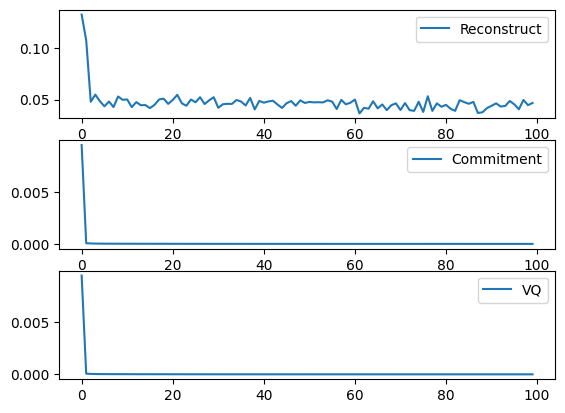

In [75]:
start, end, step = None, None, 100
figure, ax = plt.subplots(3)
ax[0].plot(history['reconstruct_loss'][start:end:step], label="Reconstruct")
ax[0].legend()
ax[1].plot(history['commitment_loss'][start:end:step], label="Commitment")
ax[1].legend()
ax[2].plot(history['vq_loss'][start:end:step], label="VQ")
ax[2].legend()
plt.show()


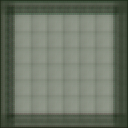

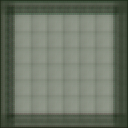

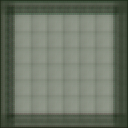

In [76]:
batch_key, _ = jax.random.split(key_infer)
eval_batch = get_batch(all_images, batch_key, size=10)
batch_infer, _, _ = model.apply(vae_params, eval_batch)
eval_images = batch_to_images(batch_infer)
eval_images[0].show()
eval_images[1].show()
eval_images[2].show()

In [77]:
codebook = vae_params['params']['codebook']
codebook.shape

(256, 64)

In [78]:
if not os.path.exists("./models"):
    os.mkdir("./models")

with open("./models/VQVAE-128-daisy-10000-steps.pickle", 'wb') as f:
    pickle.dump(vae_params, f)
